# Labeling Words - Data Creation
Simple UI from IPython widgets for labeling of words
#### Save words with:
* latters
* gap positions

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import time
import simplejson
# Import Widgets
from ipywidgets import Button, IntSlider, Text, HBox, VBox
from IPython.display import display, clear_output

# Import costume functions, corresponding to notebooks
from ocr import page, words
from ocr.normalization import imageNorm
from ocr.helpers import implt, resize

# Increase size of images
plt.rcParams['figure.figsize'] = (15.0, 5.0)

### Global variables

In [3]:
IMG = "wordTest-en"
LANG = "cz"

## Load image

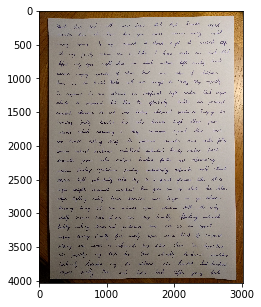

In [4]:
image = cv2.cvtColor(cv2.imread("../data/pages/%s.jpg" % IMG), cv2.COLOR_BGR2RGB)
implt(image)

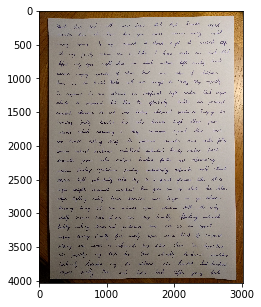

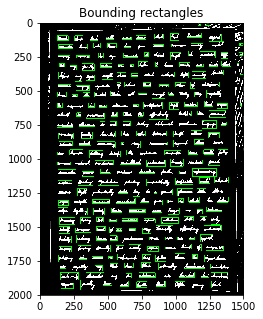

Words len: 278


In [5]:
# Crop image and get bounding boxes
crop = image # page.detection(image)
implt(crop)
bBoxes = words.detection(crop)
print("Words len:", len(bBoxes))

# Simple UI using widgets

In [6]:
class Slider:
    """
    Object for managing slider + button widgets
    Creates slider with "remove" button    
    """    
    def __init__(self, val, maxVal, controler):     
        self.slider = IntSlider(value = val,
                                max = maxVal)
        self.button = Button(description = "Remove")
        self.controler = controler
        # Display slider and button next to each other
        display(HBox([self.slider, self.button]))
        # Event handlers
        self.slider.observe(self.controler.updateSliders, names='value')
        self.button.on_click(self.remove)
        
    def getValue(self):
        return self.slider.value
        
    def remove(self, b=None):
        self.slider.close()
        self.button.close()
        self.controler.removeSlider(self)
        
    def __del__(self):
        self.slider.close()
        self.button.close()

In [7]:
class Cycler:
    """ Cycle through words, save data """
    width = 30
    height = 60
    
    def __init__(self, image, boxes, idx, actL, test):
        self.boxes = boxes       # Array of bounding boxes
        self.image = image       # Whole image
        self.index = idx         # Index of current bounding box
        self.lines_active = actL # Save gap linse or not
        self.test = test         # Separate words for testing
        self.actual = image      # Current image of word
        self.actual_raw = image  # Current image of word without normalization
        self.drawImg = image     # Image for drawing gaplines
        self.sliders = []        # Saving list of all IntSliders
        
        # Cycler GUI
        bSave = Button(description="Save")
        bNexi = Button(description="Next Image")
        text = Text(description="Save Word")
        bSave.on_click(self.save)
        bNexi.on_click(self.nextImg)
        text.on_submit(self.save)

        if GAP_LINES:
            bAddSlider = Button(description="Add Slider")
            bAddSlider.on_click(self.addSlider)
            self.buttons = VBox([HBox([bAddSlider, bSave, bNexi]), text])
        else:
            self.buttons = VBox([HBox([bSave, bNexi]), text])
            
        self.nextImg()
        
    def save(self, b=None):
        """
        Saving current word with gaplines
        save image with name structure: word_timestamp.jpg
        + txt file with gaplines position: word_timestamp.txt
        """
        ### Loading form txt file ###
        # with open('word_123.123.txt', 'r') as fp:
        #     list = simplejson.load(fp)
      
        timestamp = time.time()
        if self.lines_active:
            gaplines = sorted([slider.getValue() for slider in self.sliders])
        word = b.value
        # Sanity check
        assert not self.lines_active or len(gaplines) == len(word) + 1
        
        # Save raw image + normalized word with/without gaplines
        if self.test:
            cv2.imwrite(
                "data/test_words/" + LANG + "_raw/%s_%s.jpg" % (word, timestamp),
                cv2.cvtColor(self.actual_raw, cv2.COLOR_BGR2RGB))
#             cv2.imwrite("data/test_words/en/%s_%s.jpg" % (word, timestamp), self.actual)
        else:            
            cv2.imwrite(
                "data/words_raw/%s_%s.jpg" % (word, timestamp),
                cv2.cvtColor(self.actual_raw, cv2.COLOR_BGR2RGB))
#             cv2.imwrite("data/words_nolines/%s_%s.jpg" % (word, timestamp), self.actual)
            if self.lines_active:
                cv2.imwrite("data/words/%s_%s.jpg" % (word, timestamp), self.actual)
                with open('data/words/%s_%s.txt' % (word, timestamp), 'w') as fp:
                    simplejson.dump(gaplines, fp)
        
        # Reset text field valeu
        if hasattr(b, 'value'):
            b.value = ""
      
        self.nextImg(b)
    
    def addSlider(self, b=None, sliderVal=0, update=True):
        """ Add slider and save it to slider list """        
        newSlider = Slider(sliderVal,
                           self.actual.shape[1]-1,
                           self)
        self.sliders.append(newSlider)
        if update:
            self.updateSliders()
        
    def removeSlider(self, slider):
        """ Delete slider from sliders array """
        self.sliders.remove(slider)
        self.updateSliders()
    
    def updateSliders(self, b=None):
        """ Re-draw positions of gaplines set by sliders """
        # Clearing jupyter output for new image
        clear_output()        
        self.drawImg = cv2.cvtColor(self.actual, cv2.COLOR_GRAY2RGB)        
        for slider in self.sliders:
            self.drawLineInPos(slider.getValue())        
        implt(self.drawImg)
        
    def drawLineInPos(self, pos):
        """ Drawing vertical line in given position """            
        cv2.line(self.drawImg,
                 (pos, 0),
                 (pos, self.height),
                 (0,255,0),
                 1)

    def nextImg(self, b=None):
        """ Getting next image from the array """
        # Clear output images and delete sliders
        clear_output()
        display(self.buttons)
        
        for slider in self.sliders:
            slider.__del__()
        self.sliders = []
        
        if self.index < len(self.boxes):
            b = self.boxes[self.index]
            x1, y1, x2, y2 = b
            
            # Cuting out the word image and resizing to standard height
            img = self.image[y1:y2, x1:x2]
            img = resize(img, self.height, True)
            
            self.actual_raw = img                       
            
            if img.shape[1] < 5:
                self.index += 1
                self.nextImg()
            else:
                implt(img, t='Original')
                self.actual = imageNorm(
                    img,
                    self.height,
                    border=False,
                    tilt=True,
                    hystNorm=True)

                # Add detected gaplines
                if self.lines_active:
                    for line in charSeg.segmentation(self.actual):
                        self.addSlider(sliderVal = line, update = False)
                    self.updateSliders()
                    
                else:
                    implt(self.actual, 'gray')

                # Printing index for recovery
                print("Index: " + str(self.index))
                self.index += 1
        else:
            print("END")

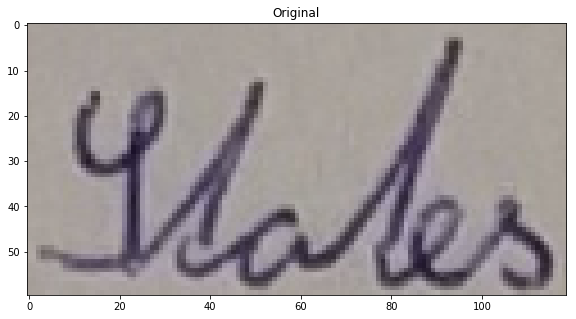

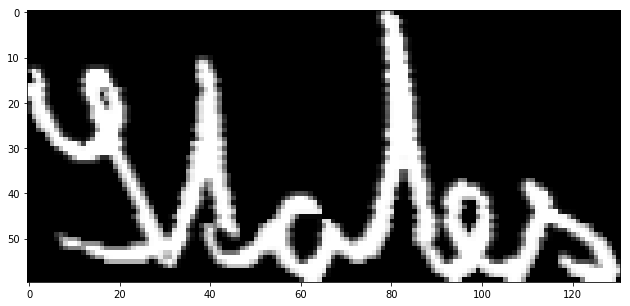

Index: 204


In [10]:
##  Last index
LAST_INDEX = 0
GAP_LINES = False
TEST = False
# Class cycling through text positions
cycler = Cycler(crop, bBoxes, LAST_INDEX, GAP_LINES, TEST)

### NOTES ###
#
#  NAME:
#  word_timestamp.jpg
#  if GAP_LINES:
#      + word_timestamp.txt - with gaps position
#
#############

In [9]:
### RULES FOR CREATING DATASET ###
#
#  Label every image
#  Set gap lines,
#  then write word and save...
#
###################################

### Space for Notes ###
#
#  Try to tilt the sliding frame
#  Or when separated, tilt saparation lines +/- 45°,
#  so that it minimize the crossing pixels
#  (maximize number of white pixels in region???)
#
#######################


